<a href="https://colab.research.google.com/github/uliang/MS9002-Data-mining-techniques/blob/master/MS9002_Python_Lab_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Python Lab 3
___

## Linear regression modelling 

In this lab, we will investigate the mpg dataset. *Source*: https://archive.ics.uci.edu/ml/datasets/auto+mpg 

__Learning objectives__: 

1. To create a linear regression model that will predict mpg from 3 discrete variables and 5 continuous variables. 
2. To learn how to create dummy variables and its relation to the interpretation of the intercept term. 
3. To see how regression coefficients are affected by the regularization parameter. 
4. To find the best regularization that optimizes the accuracy of the model. 



In [0]:
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt

In [0]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data', header=None, 
                 quoting=2, quotechar='"', delim_whitespace=True, na_values='?')

df.columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration' , 'model_year', 'origin', 'car_name']

Text(0.5, 1.0, 'Plot of mpg as a function of weight')

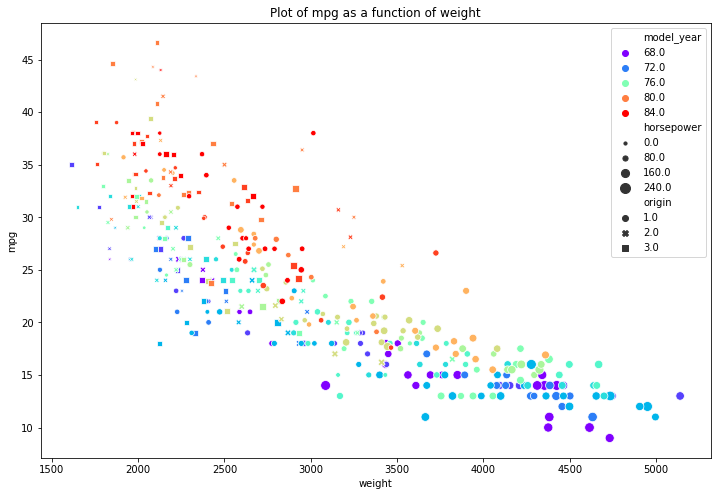

In [3]:
fig, ax = plt.subplots(1,1, figsize=(12, 8))

sns.scatterplot(x='weight', y='mpg', hue='model_year', style='origin', size='horsepower', data=df, palette='rainbow', ax=ax, sizes=(10, 100))

ax.set_title('Plot of mpg as a function of weight')

In [0]:
features = df.drop(['mpg', 'car_name'], axis=1)

target = df['mpg']


In [0]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression

In [0]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=12345)

__Basic regression model__

We model mpg as a simple additive model based on the features, all of which are considered numeric. 

__Questions__

1. Is it reasonable to model the mpg dataset with all numerical variables? 

In [0]:
lin = LinearRegression() 

pipeline = make_pipeline(SimpleImputer(), lin) 

pipeline.fit(X_train, y_train) 

In [0]:
estimator = pipeline.named_steps['linearregression']

In [0]:
pd.Series(estimator.coef_, index=features.columns)

In [0]:
pipeline.score(X_test, y_test)

__Model by discretizing origin__ 

It is highly unlikely that there is a simple additive relationship between the origin of the car and mpg, especially when origin is a code for the country which is a nominal variable. 


In [0]:
dscr_df = pd.get_dummies(df, columns=['origin'])
dscr_features = dscr_df.drop(['mpg', 'car_name'], axis=1) 

X_train, X_test, y_train, y_test = train_test_split(dscr_features, target, test_size=0.1, random_state=12345)


In [0]:
pipeline.set_params(linearregression__fit_intercept=False)

pipeline.fit(X_train, y_train)

In [0]:
estimator2 = pipeline.named_steps['linearregression']

pd.Series(estimator2.coef_, index=dscr_features.columns)

In [0]:
estimator2.score(X_test,y_test)

__Questions__

1. Notice that I did not fit an intercept term when I created dummy variables for nominal variables. Why? 

1. Is there a significant increase in $R^2$ value on the test set? What then can we say about the importance of this feature (origin)? 

2. Suggest one way in which we can control for the effect of coding nominal variables in linear regression apart from generating dummy variables? 


__Polynomial features__ 

Let's add a polynomial featurizer into this pipeline and see if non-linear relationships are an important feature. 

In [0]:
from sklearn.preprocessing import PolynomialFeatures 

pipeline.steps.insert(1, ('polynomialfeatures', PolynomialFeatures(include_bias=False)))

In [0]:
pipeline.fit(X_train, y_train)

In [0]:
pipeline.score(X_test, y_test)

__Questions__ 

1. What can you conclude from the $R^2$ score you observe in the previos cell? Are non-linear features and interactions important? 


__Adding a regularizer__

Examine the regression coefficients of the model. 

In [0]:
estimator3 = pipeline.named_steps['linearregression']

estimator3.coef_

__Questions__

1. Observe the variation and magnitude of the coefficients. What do you notice? 

2. What are the implications of unregularized regression coefficients? 


In order to sieve out features and distill the model to the simplest possible, we use a penalty factor $\alpha$ to control the size of coefficients. 

In [0]:
from sklearn.linear_model import Ridge 
from sklearn.preprocessing import StandardScaler

pipeline.set_params(linearregression=Ridge())

pipeline.steps.insert(1, ('standardscaler', StandardScaler()))

In [0]:
pipeline.steps

We also implement a grid search to identify the $\alpha$ which gives us an optimal model. 

In [0]:
import numpy as np
from sklearn.model_selection import GridSearchCV 

grid_search = GridSearchCV(pipeline, param_grid={'linearregression__alpha': np.logspace(-2,3, 20)}, 
                           n_jobs=-1, verbose=1, cv=5)

In [0]:
grid_search.fit(X_train, y_train)

In [0]:
grid_search.best_score_

In [0]:
grid_search.best_params_

In [0]:
best_pipeline = grid_search.best_estimator_
best_pipeline.score(X_test, y_test)

As seen above, selecting a suitable regularization parameter does improve scores on the test set if not maintains the same level of accuracy. 

In [0]:
estimator4 = best_pipeline.named_steps['linearregression']

In [0]:
estimator4.coef_

Notice now that the variation in regression coefficients are more reasonable. 